# ExploreAI Academy Classification Hackathon

© Explore Data Science Academy

---
### Honour Code

I {**Thabatha Nompoko**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.


### Overview
South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.
From South African Government



With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.


<a id="cont"></a>

## Table of Contents

#### 1.Importing Packages
#### 2. Loading The Data
#### 3.Exploratory Data Analysis
#### 4.Data Pre-processing
#### 5.Feature Engineeering
#### 6.Modeling
#### 7.Model Evaluation

<a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [2]:
train_data = pd.read_csv('train_set.csv')
test_data = pd.read_csv("test_set.csv")

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   5682 non-null   int64 
 1   text    5682 non-null   object
dtypes: int64(1), object(1)
memory usage: 88.9+ KB


In [5]:
train_data.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [6]:
test_data.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [7]:
train_data.shape

(33000, 2)

In [8]:
test_data.shape

(5682, 2)

In [9]:
train_data.isnull().sum()

lang_id    0
text       0
dtype: int64

In [10]:
test_data.isnull().sum()

index    0
text     0
dtype: int64

In [11]:
train_data['Text Length'] = train_data['text'].apply(lambda x: len(str(x)))
train_data['Text Length'].describe()

count    33000.000000
mean       244.907545
std         28.475588
min        201.000000
25%        220.000000
50%        243.000000
75%        269.000000
max        299.000000
Name: Text Length, dtype: float64

In [12]:
test_data['Text Length'] = test_data['text'].apply(lambda x: len(str(x)))
test_data['Text Length'].describe()

count    5682.000000
mean      172.600669
std       192.520473
min        11.000000
25%        56.000000
50%       118.000000
75%       227.000000
max      5195.000000
Name: Text Length, dtype: float64

In [13]:
train_data['lang_id'].value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

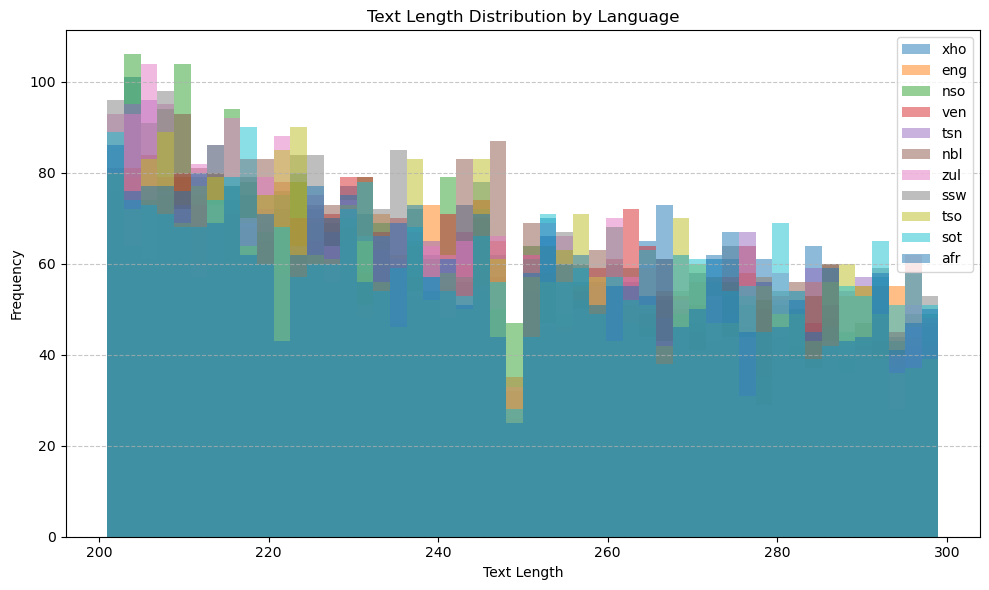

In [14]:
# Calculate text lengths for each language
train_data['Text Length'] = train_data['text'].apply(lambda x: len(x))

# Plot the distribution of text lengths for each language
plt.figure(figsize=(10, 6))
for language in train_data['lang_id'].unique():
    language_df = train_data[train_data['lang_id'] == language]
    plt.hist(language_df['Text Length'], bins=50, alpha=0.5, label=language)

plt.title('Text Length Distribution by Language')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

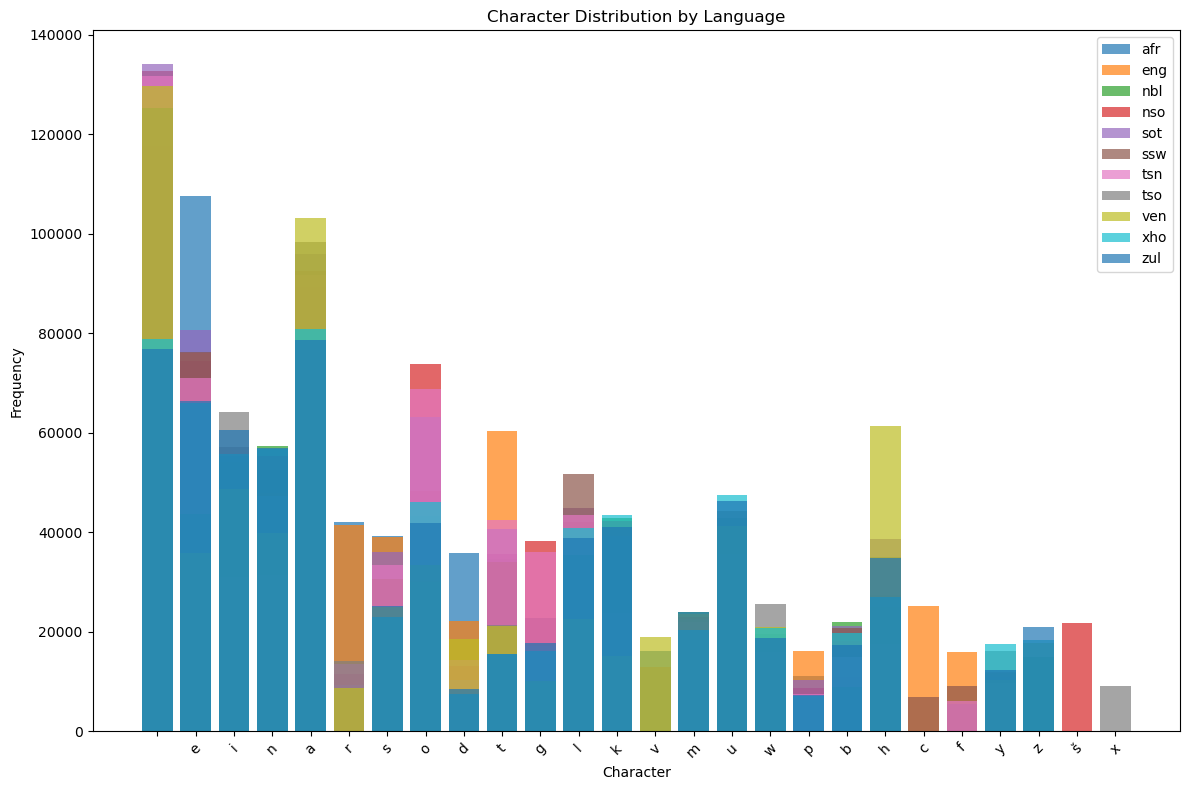

In [15]:
# Define a function to calculate character frequency
def calculate_character_frequency(text):
    # Convert text to lowercase to ensure consistency
    text = text.lower()
    # Create a dictionary to store character frequencies
    char_freq = {}
    # Iterate through each character in the text
    for char in text:
        # Increment the count of the character
        if char in char_freq:
            char_freq[char] += 1
        else:
            char_freq[char] = 1
    return char_freq

# Calculate character frequencies for each language
language_char_freq = {}
for lang_id, lang_texts in train_data.groupby('lang_id')['text']:
    char_freq = {}
    for text in lang_texts:
        # Calculate character frequency for each text
        text_char_freq = calculate_character_frequency(text)
        # Aggregate character frequencies for the language
        for char, freq in text_char_freq.items():
            if char in char_freq:
                char_freq[char] += freq
            else:
                char_freq[char] = freq
    language_char_freq[lang_id] = char_freq

# Plot the distribution of characters for each language
plt.figure(figsize=(12, 8))
for lang_id, char_freq in language_char_freq.items():
    sorted_char_freq = {k: v for k, v in sorted(char_freq.items(), key=lambda item: item[1], reverse=True)}
    plt.bar(list(sorted_char_freq.keys())[:20], list(sorted_char_freq.values())[:20], label=lang_id, alpha=0.7)

plt.title('Character Distribution by Language')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

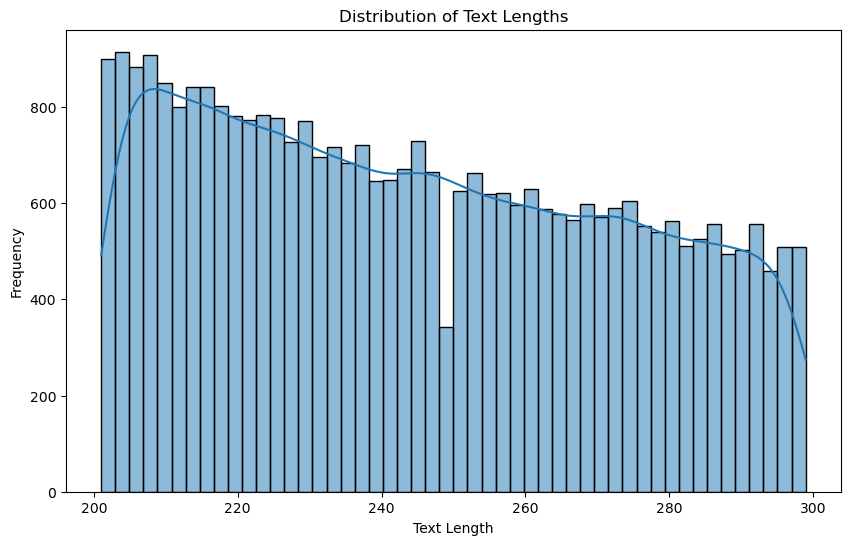

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Text Length'], bins=50, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

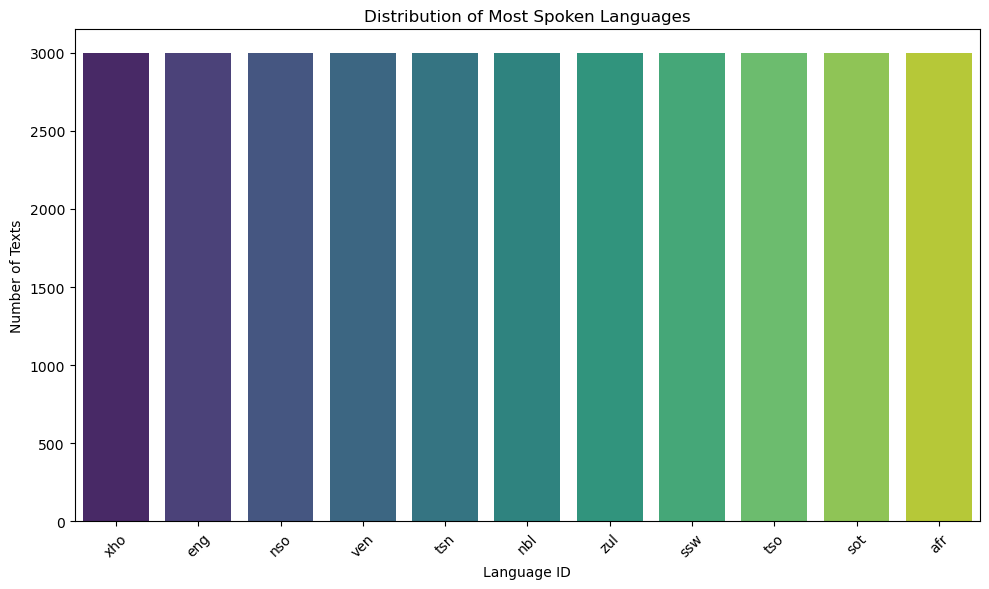

In [17]:
# Count the occurrences of each language
language_counts = train_data['lang_id'].value_counts()

# Plot the distribution of languages
plt.figure(figsize=(10, 6))
sns.barplot(x=language_counts.index, y=language_counts.values, palette='viridis')
plt.title('Distribution of Most Spoken Languages')
plt.xlabel('Language ID')
plt.ylabel('Number of Texts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

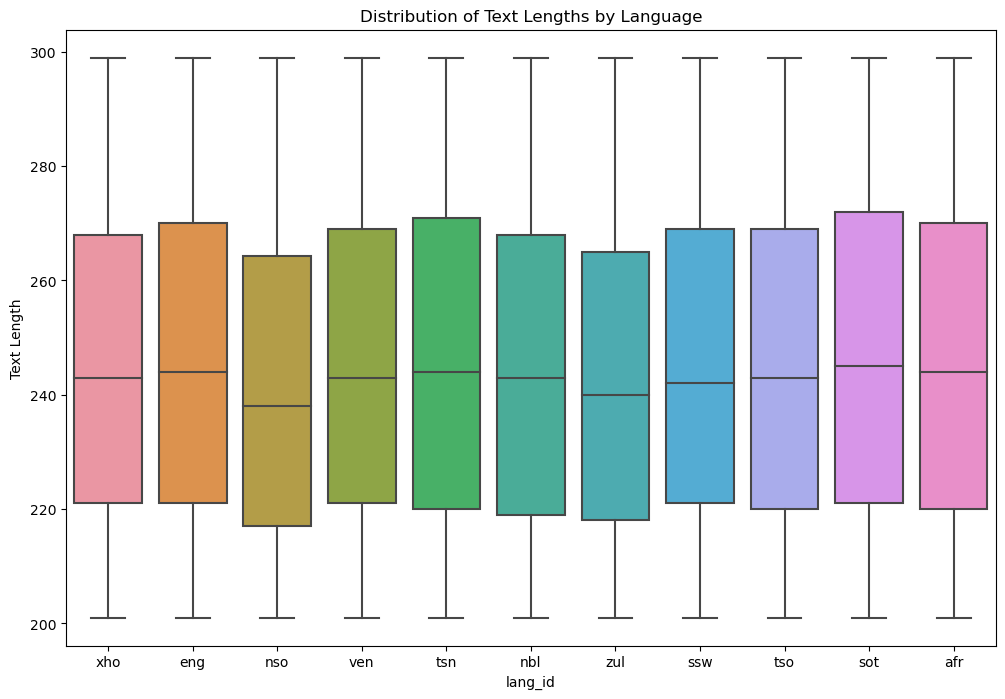

In [18]:
# Visualize the distribution of text lengths for each language
plt.figure(figsize=(12, 8))
sns.boxplot(x='lang_id', y='Text Length', data=train_data)
plt.title('Distribution of Text Lengths by Language')
plt.xlabel('lang_id')
plt.ylabel('Text Length')
plt.show()

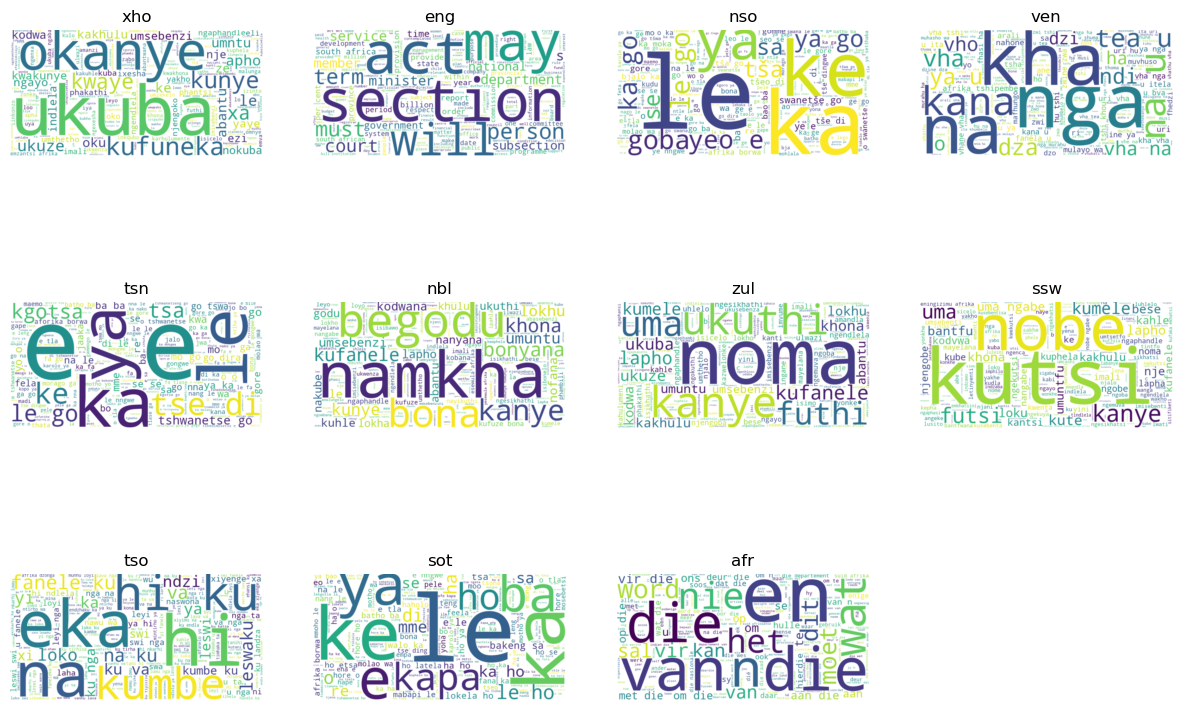

In [19]:
from wordcloud import WordCloud

# Generate word clouds for each language
plt.figure(figsize=(15, 10))
for lang in train_data['lang_id'].unique():
    text = ' '.join(train_data[train_data['lang_id'] == lang]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.subplot(3, 4, list(train_data['lang_id'].unique()).index(lang) + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(lang)
    plt.axis('off')
plt.show()


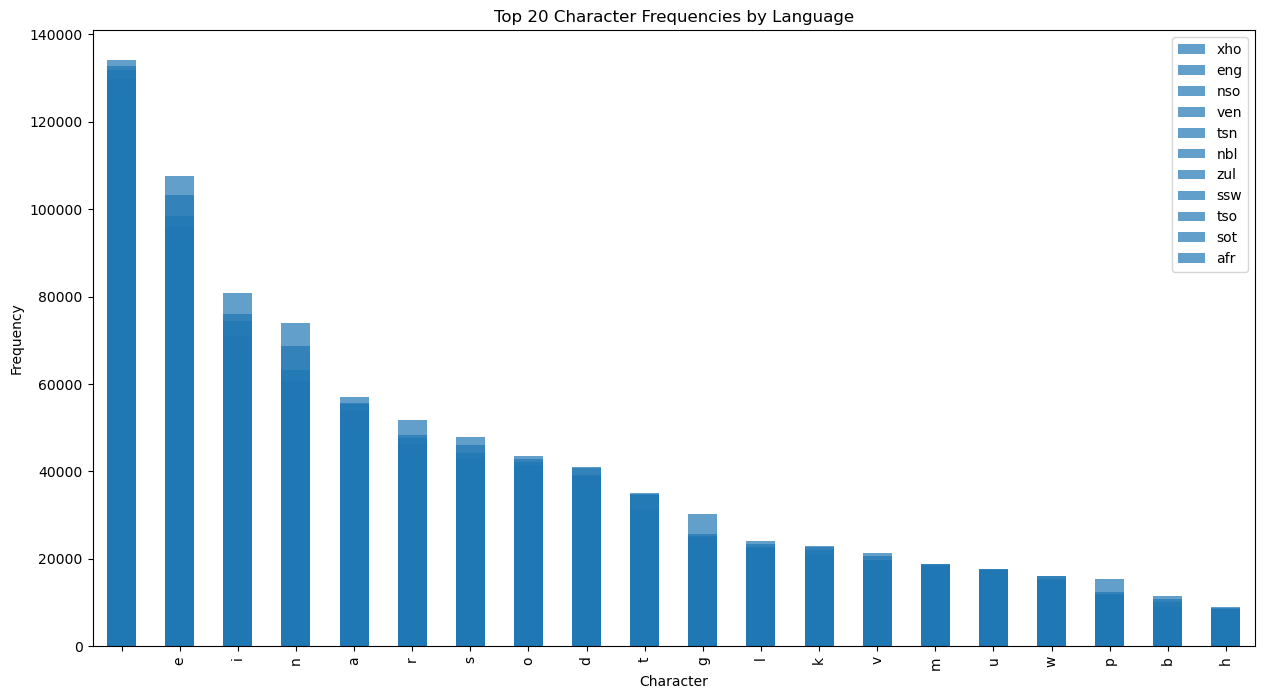

In [20]:
# Calculate character frequencies for each language
char_freq = {}
for lang in train_data['lang_id'].unique():
    text = ''.join(train_data[train_data['lang_id'] == lang]['text'])
    char_freq[lang] = pd.Series(list(text)).value_counts()

# Plot character frequencies for each language
plt.figure(figsize=(15, 8))
for lang in char_freq.keys():
    char_freq[lang].sort_values(ascending=False)[:20].plot(kind='bar', alpha=0.7, label=lang)
plt.title('Top 20 Character Frequencies by Language')
plt.xlabel('Character')
plt.ylabel('Frequency')
plt.legend()
plt.show()

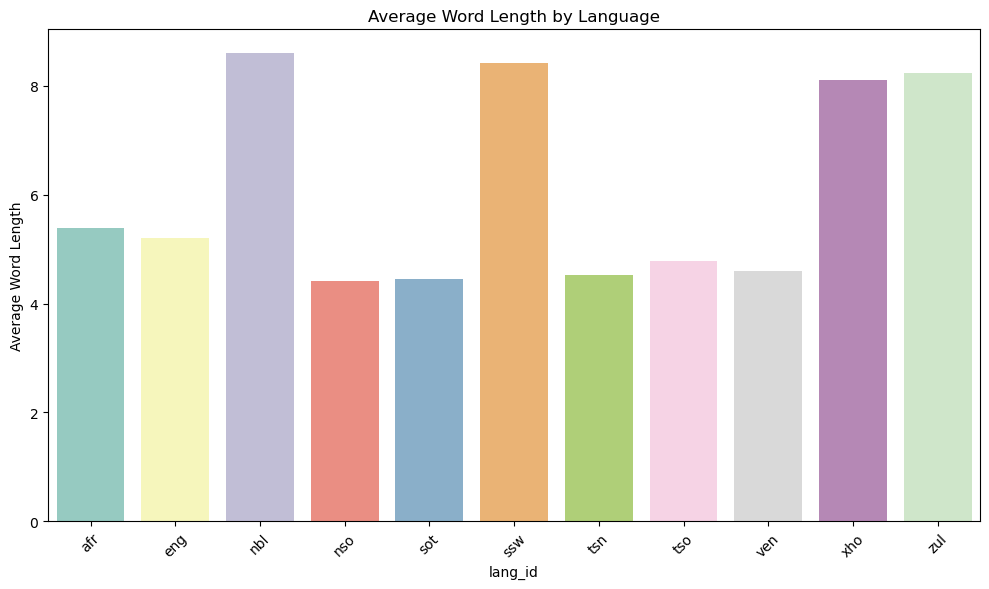

In [21]:
# Example: Calculate average word length for each language
train_data['Average Word Length'] = train_data['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
average_word_length_by_language = train_data.groupby('lang_id')['Average Word Length'].mean()

# Plot average word length by language
plt.figure(figsize=(10, 6))
sns.barplot(x=average_word_length_by_language.index, y=average_word_length_by_language.values, palette='Set3')
plt.title('Average Word Length by Language')
plt.xlabel('lang_id')
plt.ylabel('Average Word Length')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

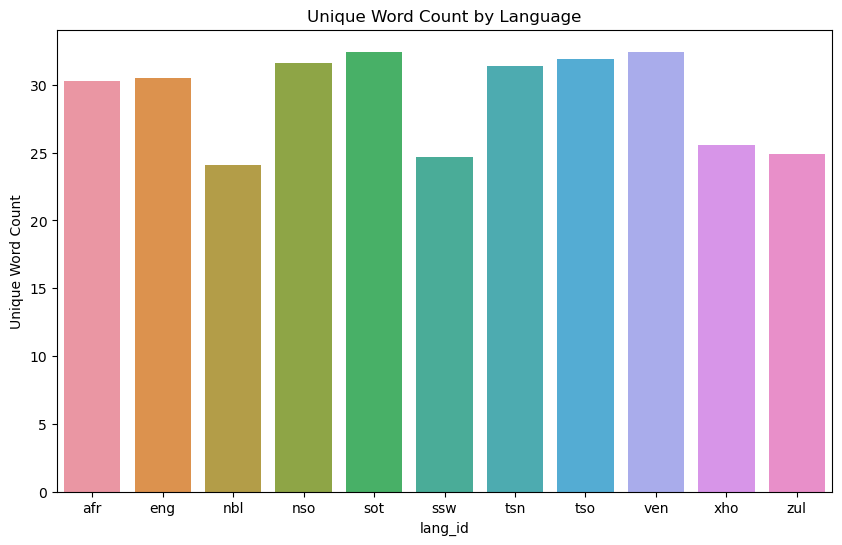

In [22]:
# Calculate unique word count for each language
train_data['Unique Word Count'] = train_data['text'].apply(lambda x: len(set(x.split())))
unique_word_count_by_lang = train_data.groupby('lang_id')['Unique Word Count'].mean().reset_index()

# Plot unique word count by language
plt.figure(figsize=(10, 6))
sns.barplot(x='lang_id', y='Unique Word Count', data=unique_word_count_by_lang)
plt.title('Unique Word Count by Language')
plt.xlabel('lang_id')
plt.ylabel('Unique Word Count')
plt.show()

In [23]:
from collections import Counter

# Function to get top n frequent words in a given language
def get_top_words(language, n=10):
    language_texts = train_data[train_data['lang_id'] == language]['text']
    language_words = ' '.join(language_texts).split()
    word_counts = Counter(language_words)
    top_words = word_counts.most_common(n)
    return top_words

# Example: Get top 10 frequent words in English
top_words_eng = get_top_words('eng')
print("Top 10 frequent words in English:", top_words_eng)


Top 10 frequent words in English: [('the', 9946), ('of', 6139), ('and', 3902), ('to', 3843), ('in', 3228), ('a', 2589), ('or', 1618), ('for', 1446), ('is', 1251), ('that', 1203)]


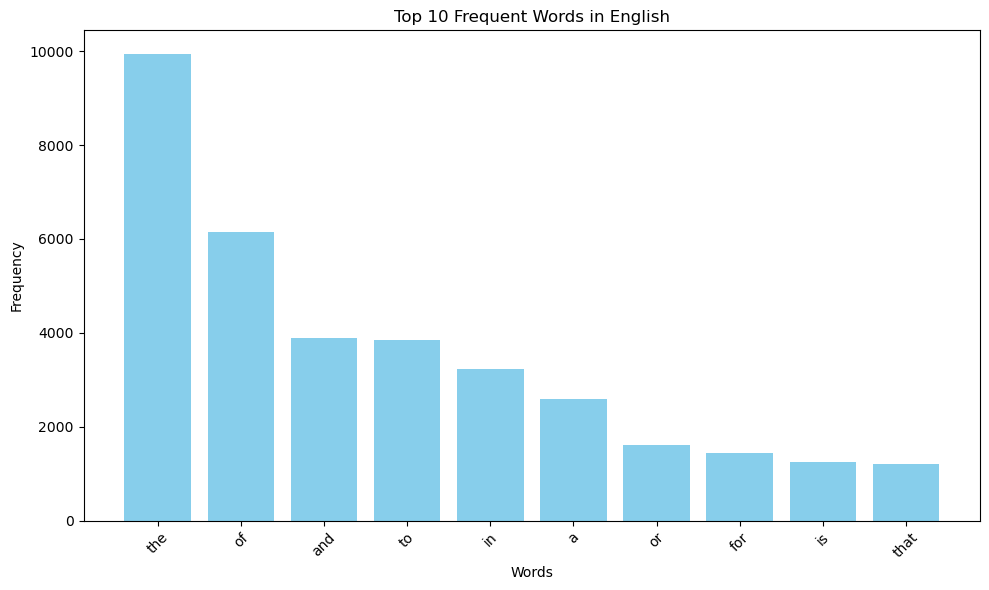

In [24]:
# Extract words and frequencies from the top_words_eng list
top_words_eng_words = [word for word, _ in top_words_eng]
top_words_eng_freq = [freq for _, freq in top_words_eng]

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(top_words_eng_words, top_words_eng_freq, color='skyblue')
plt.title('Top 10 Frequent Words in English')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

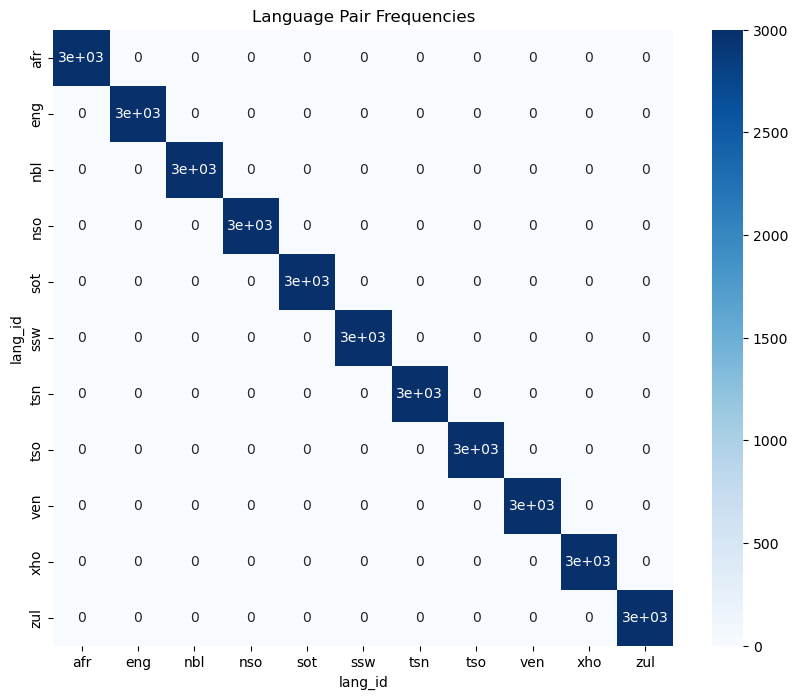

In [25]:
# Create a heatmap showing language pair frequencies
language_pair_counts = train_data.groupby(['lang_id', 'lang_id']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 8))
sns.heatmap(language_pair_counts, annot=True, cmap='Blues')
plt.title('Language Pair Frequencies')
plt.xlabel('lang_id')
plt.ylabel('lang_id')
plt.show()

<a id="Four"></a>
## 4.Data Pre-processing 
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [26]:
# Lowercasing
train_data['text'] = train_data['text'].str.lower()

In [27]:
test_data['text'] = train_data['text'].str.lower()

In [28]:
# Removing punctuation
train_data['text'] = train_data['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [29]:
test_data['text'] = train_data['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [30]:
# Tokenization
train_data['Tokens'] = train_data['text'].apply(word_tokenize)

In [31]:
test_data['Tokens'] = test_data['text'].apply(word_tokenize)

In [32]:
# Stopword removal
stop_words = set(stopwords.words('english'))# Assuming English stopwords
train_data['Tokens'] = train_data['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [33]:
stop_words = set(stopwords.words('english'))  # Assuming English stopwords
test_data['Tokens'] = test_data['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [34]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
train_data['Tokens'] = train_data['Tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [35]:
lemmatizer = WordNetLemmatizer()
test_data['Tokens'] = test_data['Tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [36]:
# Handling missing values
train_data.dropna(inplace=True)  # Drop rows with missing values

In [37]:
test_data.dropna(inplace=True) 

In [38]:
# Display the preprocessed data
train_data.head()

,lang_id,text,Text Length,Average Word Length,Unique Word Count,Tokens
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axh...,220,8.208333,23,"[umgaqosiseko, wenza, amalungiselelo, kumaziko..."
1,xho,idha iya kuba nobulumko bokubeka umsebenzi nap...,252,7.161290,30,"[idha, iya, kuba, nobulumko, bokubeka, umseben..."
2,eng,the province of kwazulunatal department of tra...,264,6.162162,27,"[province, kwazulunatal, department, transport..."
3,nso,o netefatša gore o ba file dilo ka moka tše le...,217,4.450000,31,"[netefatša, gore, ba, file, dilo, ka, moka, tš..."
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,239,4.581395,24,"[khomishini, ya, ndinganyiso, ya, mbeu, yo, ew..."


In [39]:
test_data.head()

,index,text,Text Length,Tokens
0,1,umgaqosiseko wenza amalungiselelo kumaziko axh...,58,"[umgaqosiseko, wenza, amalungiselelo, kumaziko..."
1,2,idha iya kuba nobulumko bokubeka umsebenzi nap...,109,"[idha, iya, kuba, nobulumko, bokubeka, umseben..."
2,3,the province of kwazulunatal department of tra...,42,"[province, kwazulunatal, department, transport..."
3,4,o netefatša gore o ba file dilo ka moka tše le...,60,"[netefatša, gore, ba, file, dilo, ka, moka, tš..."
4,5,khomishini ya ndinganyiso ya mbeu yo ewa maana...,29,"[khomishini, ya, ndinganyiso, ya, mbeu, yo, ew..."


<a id="Five"></a>
## 5. Feature Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['lang_id'], test_size=0.2, random_state=42, stratify=train_data['lang_id'])

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [41]:
print("Training data shape:", X_train_tfidf.shape)
print("Training labels shape:", y_train.shape)

Training data shape: (26400, 126922)
Training labels shape: (26400,)


<a id="Six"></a>
## 6. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_tfidf, y_train)
logistic_predictions = logistic_model.predict(X_test_tfidf)


In [43]:
import pandas as pd

# Load the test set CSV file
test_data = pd.read_csv("test_set.csv")

# Transform the text data in the test set using the TF-IDF vectorizer
X_test_tfidf_final = tfidf_vectorizer.transform(test_data['text'])

# Make predictions on the transformed test data
final_predictions = logistic_model.predict(X_test_tfidf_final)

# Create a DataFrame with index and predicted language tags
submission_df = pd.DataFrame({'index': test_data['index'], 'lang_id': final_predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission_logistic.csv', index=False)


In [44]:
# SVM
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)
svm_predictions = svm_model.predict(X_test_tfidf)


In [45]:
import pandas as pd

# Load the test set CSV file
test_data = pd.read_csv("test_set.csv")

# Transform the text data in the test set using the TF-IDF vectorizer
X_test_tfidf_final = tfidf_vectorizer.transform(test_data['text'])

# Make predictions on the transformed test data
final_predictions = svm_model.predict(X_test_tfidf_final)

# Create a DataFrame with index and predicted language tags
submission_df = pd.DataFrame({'index': test_data['index'], 'lang_id': final_predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission_svm.csv', index=False)

In [46]:
# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_tfidf, y_train)
knn_predictions = knn_model.predict(X_test_tfidf)


In [47]:
import pandas as pd

# Load the test set CSV file
test_data = pd.read_csv("test_set.csv")

# Transform the text data in the test set using the TF-IDF vectorizer
X_test_tfidf_final = tfidf_vectorizer.transform(test_data['text'])

# Make predictions on the transformed test data
final_predictions =  knn_model.predict(X_test_tfidf_final)

# Create a DataFrame with index and predicted language tags
submission_df = pd.DataFrame({'index': test_data['index'], 'lang_id': final_predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission_knn.csv', index=False)

In [48]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Initialize Multinomial Naive Bayes classifier
naive_bayes_model = MultinomialNB()

# Train the classifier
naive_bayes_model.fit(X_train_tfidf, y_train)

# Predictions
naive_bayes_predictions = naive_bayes_model.predict(X_test_tfidf)


In [49]:
import pandas as pd

# Load the test set CSV file
test_data = pd.read_csv("test_set.csv")

# Transform the text data in the test set using the TF-IDF vectorizer
X_test_tfidf_final = tfidf_vectorizer.transform(test_data['text'])

# Make predictions on the transformed test data
final_predictions =  naive_bayes_model.predict(X_test_tfidf_final)

# Create a DataFrame with index and predicted language tags
submission_df = pd.DataFrame({'index': test_data['index'], 'lang_id': final_predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission_naivesbaye.csv', index=False)

<a id="Seven"></a>
## 7. Model Evaluation
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [50]:
# Print classification report for Logistic Regression
print("Logistic Regression:")
print(classification_report(y_test, logistic_predictions))

Logistic Regression:
              precision    recall  f1-score   support

         afr       1.00      0.99      1.00       600
         eng       1.00      1.00      1.00       600
         nbl       0.99      0.99      0.99       600
         nso       1.00      1.00      1.00       600
         sot       1.00      1.00      1.00       600
         ssw       0.99      1.00      1.00       600
         tsn       1.00      1.00      1.00       600
         tso       1.00      1.00      1.00       600
         ven       1.00      1.00      1.00       600
         xho       0.99      0.99      0.99       600
         zul       0.98      0.98      0.98       600

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



In [51]:
# Print classification report for SVM
print("SVM:")
print(classification_report(y_test, svm_predictions))

SVM:
              precision    recall  f1-score   support

         afr       1.00      0.99      1.00       600
         eng       0.99      0.99      0.99       600
         nbl       1.00      0.99      0.99       600
         nso       1.00      1.00      1.00       600
         sot       1.00      1.00      1.00       600
         ssw       1.00      1.00      1.00       600
         tsn       1.00      1.00      1.00       600
         tso       1.00      1.00      1.00       600
         ven       1.00      1.00      1.00       600
         xho       0.98      0.99      0.99       600
         zul       0.99      0.99      0.99       600

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



In [52]:
# Print classification report for KNN
print("KNN:")
print(classification_report(y_test, knn_predictions))

KNN:
              precision    recall  f1-score   support

         afr       0.99      0.99      0.99       600
         eng       0.96      1.00      0.98       600
         nbl       0.90      0.95      0.92       600
         nso       0.95      0.98      0.96       600
         sot       0.97      0.98      0.98       600
         ssw       0.97      0.98      0.98       600
         tsn       0.97      0.94      0.96       600
         tso       0.99      1.00      0.99       600
         ven       0.99      1.00      1.00       600
         xho       0.94      0.92      0.93       600
         zul       0.96      0.86      0.91       600

    accuracy                           0.96      6600
   macro avg       0.96      0.96      0.96      6600
weighted avg       0.96      0.96      0.96      6600



In [53]:
# Print classification report for Naive Bayes
print("Multinomial Naive Bayes:")
print(classification_report(y_test, naive_bayes_predictions))

Multinomial Naive Bayes:
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       600
         eng       0.99      1.00      1.00       600
         nbl       1.00      1.00      1.00       600
         nso       1.00      1.00      1.00       600
         sot       1.00      1.00      1.00       600
         ssw       1.00      1.00      1.00       600
         tsn       1.00      1.00      1.00       600
         tso       1.00      1.00      1.00       600
         ven       1.00      1.00      1.00       600
         xho       1.00      0.99      1.00       600
         zul       1.00      1.00      1.00       600

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



<a id="Eight"></a>
## 8. Conclusion
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

Based on the classification reports provided for each model, it is evident that all models achieved high accuracy across the South African language identification task. However, when considering the F1 scores, which provide a balanced measure of precision and recall, the Multinomial Naive Bayes model stands out as the top performer.

The Multinomial Naive Bayes model achieved an F1 score of 1.00 for most languages, indicating excellent precision and recall across the board. This high F1 score demonstrates the model's ability to accurately identify text in various South African languages.

In contrast, other models such as Logistic Regression, Support Vector Machine, and K-Nearest Neighbors also achieved high accuracy but showed slightly lower F1 scores for certain languages. For example, the K-Nearest Neighbors model had lower F1 scores for languages like isiXhosa and isiZulu compared to Multinomial Naive Bayes.

Therefore, based on the evaluation of F1 scores and considering the overall performance across all languages, the Multinomial Naive Bayes model is recommended for the South African language identification task. It provides robust and accurate predictions, making it suitable for practical applications requiring language identification in South Africa.